In [5]:
from numba import jit #library that compiles code to make things a LOT faster
import numpy as np #numpy for handling of specific types and arrays
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

@jit(inline='always')
def getBit(cont, bitnum, end):
	return (cont >> (end - bitnum))&1

@jit(inline='always')
def getBit64(cont, bitnum):
	return ((cont>>(63-bitnum))&1)

@jit
def __determinePowerOf2(M):
	if M <= 0: #invalid
		return -1
	elif int(M) != M:
		return -1
	elif (M & (M - 1)) != 0:
		return -1
	else:
		i = 0
		while i < 64:
			if M == 1:
				return i
			else:
				M = (M>>1)
				i += 1
		return -1

@jit
def compressWithRiceCoding(waveIn, M):

	out = []
	temp = np.uint64(0)
	loc = 0
	end = 32
	rShift = __determinePowerOf2(M) #figure out what the number of bits to shift for the remainder is
	if rShift == -1:
		print('M value passed was improper: M>0, power of 2, and integer')
		return np.empty(1, dtype=np.uint32)
	rShift = np.uint16(rShift)
	rShiftVal = np.uint16((np.uint64(1)<<rShift)-1)
	giveup = 8
	for i in range(0, len(waveIn)):
		sign = int(waveIn[i] >=0)
		orig = np.int16(abs(waveIn[i]))
		q = np.uint16(orig>>rShift)
		r = np.uint16(orig&rShiftVal)
		locshift = 0
		if q < giveup: #in the case the system can do the compression just fine
			temp = np.uint64((temp<<np.uint64(q+1))|np.uint64(1)) #shift to the left that many values + 1
			locshift = q+1 #keep track of the current location
			if sign == 1:
				temp=temp<<np.uint64(1)
			else:
				temp = (temp<<np.uint64(1))|np.uint64(1)
			#now handle the remainder
			temp = (temp<<np.uint64(rShift))|np.uint64(r)
			loc+= 1 + rShift + locshift
		else: #if the quotient is too large, do the giveup signal
			temp = (temp << np.uint64(giveup + 1))|np.uint64(1);
			temp = temp << np.uint64(16);
			if waveIn[i] >= 0:
				temp = temp|np.uint64(waveIn[i])
			else:
				temp = temp|np.uint64(waveIn[i]+32768) #this is 2**15, our values must be smaller than 2**15 so this lets the decoder know it was negative
			loc += giveup + 1 + 16 #the length of the giveup signal, 1 for the end code, and then 16 for the length of the datapoint
		if loc>=end: # we have filled 32 bits worth of stuff up, write that
			outVal=temp >> np.uint64(loc - end)
			temp = temp&np.uint64(np.uint64(1<<(loc-end))-1)
			out.append(outVal)
			loc = loc - end
	if loc!=0: #if at the end we haven't freed the 32 bit buffer yet
		outVal = temp<<np.uint64(end - loc)
		out.append(outVal)
	out = np.array(out, dtype=np.uint32) #return the output compressed data as unsigned integers
	return out

@jit
def decompressWithRiceCoding(compressedIn, length, M):

	compressedLength = len(compressedIn)
	bit = 0
	readval = 0
	bitloc = 0
	#load in the first buffer
	read = compressedIn[0]
	read = read << np.uint64(32)
	read = read|np.uint64(compressedIn[1])
	#set up the remainder shift values, assuming that m = 8
	rShift = __determinePowerOf2(M) #figure out what the number of bits to shift for the remainder is
	if rShift == -1:
		print('M value passed was improper: M>0, power of 2, and integer')
		return np.empty(length, dtype=np.int16)
	rShift = np.uint16(rShift)
	rShiftVal = np.uint16((np.uint16(1)<<rShift)-1)
	val = 0
	waveOut = np.zeros(length, dtype=np.int16)
	firstVal = 0
	bit = 0
	#reverse the bits on this
	for i in range(0, length): #iterate over each expected output datapoint
		q = np.uint64(0)
		while not getBit64(read,bit):
			q+=1
			bit+=1
		bit+=1
		if q == 8: #this is the case when the quotient was too large
			val = (read >> np.uint64((48-bit))&np.uint64(32767)) #48 because of 64 - 16, 32767 = 2**15 - 1
			if val > 16383:
				val = val - 32768
			bit += 16
		else:
			#get the sign of the value now
			sign = ((np.uint16(getBit64(read, bit))^1)<<1)-1
			bit+=1
			#now get the remainder
			r = (read>>np.uint64(64 - rShift - bit))&np.uint64(rShiftVal) #(read>>(64-rshift-bit))&rshifthigh;
			bit += rShift #//rShift
			val = (np.uint64(q)<<np.uint64(rShift))+r 
			val = sign*val
		waveOut[i] = val
		if bit >= 32: #read in more to the buffer
			bit = bit - 32
			bitloc+=1
			read = compressedIn[bitloc]
			read = read << np.uint64(32)
			if bitloc != compressedLength - 1:
				read = read|compressedIn[bitloc + 1]
	return waveOut

Text(0, 0.5, 'Compression Ratio')

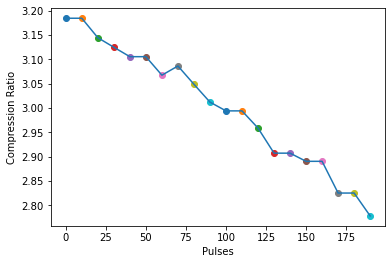

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd


comp_ratio = []

nbins = 1000
npulse = 200
pulsestep = 10

x_axis = np.arange(0, npulse, pulsestep)

for value in range(0, npulse, pulsestep):
   
    
    x = np.zeros(nbins) 
      
    
    for i in range(nbins):
        if np.random.random() < value/nbins :
            x[i] = 1
  
  
    
    t = np.linspace(0, 1000)
    d = np.exp(-t/200)

    filtered = signal.convolve(x,d, mode='same')
    
    
   
    
        

    
    
    filt2 = np.zeros(len(filtered))
    filt2[0]=filtered[0]
    filt2[1:] = [nxt-cur for cur, nxt in zip(filtered, filtered[1:])]

    y = np.array([int(value*2**5) for value in filt2])
    
    test = np.array(y, dtype=np.int16) #original array of data stored as signed 16 bit integers
    m = 8 #golomb/rice tuning parameter
    compressed = compressWithRiceCoding(test, m)

    compRatio =test.nbytes/compressed.nbytes
    comp_ratio.append(compRatio)
 
    plt.scatter(value, compRatio)
    


#print("compratio",comp_ratio)
plt.plot(x_axis,comp_ratio)
plt.xlabel("Pulses")
plt.ylabel("Compression Ratio")

Text(0, 0.5, 'Compression Ratio')

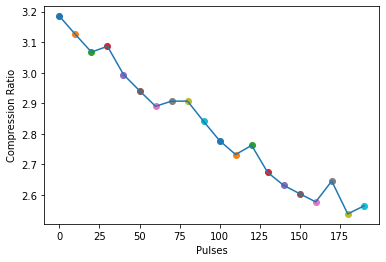

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd


comp_ratio = []



x_axis = np.arange(0, npulse, pulsestep)

for value in range(0, npulse, pulsestep):
   
    
    x = np.zeros(nbins) 
      
    
    for i in range(nbins):
        if np.random.random() < value/nbins :
            x[i] = 1
  
  
    
    t = np.linspace(0, 1000, 1000)
    d = np.exp(-t/200)

    filtered = signal.convolve(x,d, mode='same')
    
    
   
    
        

    
    
    filt2 = np.zeros(len(filtered))
    filt2[0] = filtered[0]
    filt2[1:] = [nxt-cur for cur, nxt in zip(filtered, filtered[1:])]
    
    D_Delta = np.zeros(len(filt2))
    D_Delta[0] = filt2[0]
    D_Delta[1:] = [sec-first for first, sec in zip(filt2, filt2[1:])]
    
   

    y = np.array([int(value*2**5) for value in D_Delta])
    
    test = np.array(y, dtype=np.int16) #original array of data stored as signed 16 bit integers
    m = 8 #golomb/rice tuning parameter
    compressed = compressWithRiceCoding(test, m)

    compRatio =test.nbytes/compressed.nbytes
    comp_ratio.append(compRatio)
 
    plt.scatter(value, compRatio)
    


#print("compratio",comp_ratio)
plt.plot(x_axis,comp_ratio)
plt.xlabel("Pulses")
plt.ylabel("Compression Ratio")

Text(0, 0.5, 'Compression Ratio')

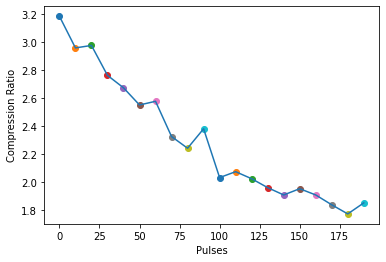

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd


comp_ratio = []


x_axis = np.arange(0, npulse, pulsestep)

for value in range(0, npulse, pulsestep):
   
    
    x = np.zeros(nbins) 
      
    
    for i in range(nbins):
        if np.random.random() < value/nbins :
            x[i] = 1
  
  
    
    t = np.linspace(0, 1000)
    d = np.exp(-t/200)

    filtered = signal.convolve(x,d, mode='same')
    
    
   
    
        

    
    
    filt2 = np.zeros(len(filtered))
    filt2[0] = filtered[0]
    filt2[1:] = [nxt-cur for cur, nxt in zip(filtered, filtered[1:])]
    
    D_Delta = np.zeros(len(filt2))
    D_Delta[0] = filt2[0]
    D_Delta[1:] = [sec-first for first, sec in zip(filt2, filt2[1:])]
    
    D_Delta1 = np.zeros(len(filt2))
    D_Delta1[0] = D_Delta[0]
    D_Delta1[1:] = [sec-first for first, sec in zip(D_Delta, D_Delta[1:])]


    y = np.array([int(value*2**5) for value in D_Delta1])
    
    test = np.array(y, dtype=np.int16) #original array of data stored as signed 16 bit integers
    m = 8 #golomb/rice tuning parameter
    compressed = compressWithRiceCoding(test, m)

    compRatio =test.nbytes/compressed.nbytes
    comp_ratio.append(compRatio)
 
    plt.scatter(value, compRatio)
    


#print("compratio",comp_ratio)
plt.plot(x_axis,comp_ratio)
plt.xlabel("Pulses")
plt.ylabel("Compression Ratio")